<a href="https://colab.research.google.com/github/sefahw/machine-learning-assignment/blob/main/neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score 

In [3]:
from keras.datasets import mnist
(x_train,y_train),(x_test,y_test)=mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
print(x_train.shape
      )
print(x_test.shape)
print(x_train[0].dtype)

(60000, 28, 28)
(10000, 28, 28)
uint8


In [5]:
x_train=x_train.reshape(-1,784)
x_test=x_test.reshape(-1,784)
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


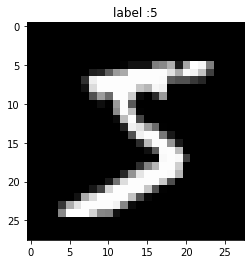

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
index=0
image=x_train[index].reshape(28,28)
plt.imshow(image,'gray')
plt.title('label :{}'.format(y_train[index]))
plt.show()

In [7]:
x_train=x_train.astype(np.float)
x_test=x_test.astype(np.float)
x_train/=255
x_test/=255
print(x_train.max())
print(x_test.min())

<ipython-input-7-faaf96f9f63a>:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_train=x_train.astype(np.float)
<ipython-input-7-faaf96f9f63a>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_test=x_test.astype(np.float)


1.0
0.0


In [8]:
from sklearn.model_selection import train_test_split

x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=0.2)
print(x_train.shape)
print(x_val.shape)

(48000, 784)
(12000, 784)


In [9]:
from sklearn.preprocessing import OneHotEncoder
enc=OneHotEncoder(handle_unknown='ignore',sparse=False)
y_train_one_hot =enc.fit_transform(y_train[:,np.newaxis])
y_val_one_hot=enc.transform(y_val[:,np.newaxis])
print(y_train.shape)
print(y_train_one_hot.shape)
print(y_train_one_hot.dtype)

(48000,)
(48000, 10)
float64


In [10]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [11]:
get_mini_batch = GetMiniBatch(x_train, y_train, batch_size=20)

print(len(get_mini_batch)) # 2400
print(get_mini_batch[5]) # 5番目のミニバッチが取得できる
for mini_x_train, mini_y_train in get_mini_batch:
    # このfor文内でミニバッチが使える
    pass

2400
(array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([9, 4, 7, 8, 4, 7, 9, 6, 1, 0, 1, 1, 7, 3, 5, 2, 1, 7, 5, 1],
      dtype=uint8))


<ipython-input-10-b95c4ffc9059>:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)


In [12]:
class ScratchSimpleNeuralNetrowkClassifier():
    
    def __init__(self, n_epoch=50, n_features=784, n_nodes1=400, n_nodes2=200, 
                 n_output=10, sigma=0.01, n_batch=20, 
                 activate_function_key='tanh', lr = 0.01, verbose = False):
        
        self.n_epoch = n_epoch
        self.n_features = n_features
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        self.sigma = sigma
        self.n_batch = n_batch
        self.activate_function_key = activate_function_key
        self.lr = lr
        self.verbose = verbose
        
    def initial_weight(self):
        self.W1 = self.sigma * np.random.randn(self.n_features, self.n_nodes1)
        self.b1 = np.zeros(self.n_nodes1)
        self.W2 = self.sigma * np.random.randn(self.n_nodes1, self.n_nodes2)
        self.b2 = np.zeros(self.n_nodes2)
        self.W3 = self.sigma * np.random.randn(self.n_nodes2, self.n_output)
        self.b3 = np.zeros(self.n_output)
        
    def activation_function(self,X):
        if self.activate_function_key == 'sigmoid':
            return 1/(1+np.exp(-X))
        
        elif self.activate_function_key == 'tanh':
            return np.tanh(X)
    
    def softmax(self,X):
        
        return np.exp(X-np.max(X))/np.sum(np.exp(X-np.max(X)),axis=1,keepdims=True)
    
    def loss_function(self,y,yt):
        delta = 1e-7
        return -np.mean(yt*np.log(y+delta))
    
    def gradient_descent(self,X,y,yt):
        
            # 3rd layer
            delta_a3 = (y-yt)/self.n_batch
            delta_b3 = np.sum(delta_a3,axis=0)
            delta_W3 = np.dot(self.z2.T,delta_a3)
            delta_z2 = np.dot(delta_a3,self.W3.T)
        
            self.W3 -= self.lr*delta_W3
            self.b3 -= self.lr*delta_b3
        
            # 2nd layer
            if self.activate_function_key == 'sigmoid':
                delta_a2 = delta_z2*(1-self.activation_function(self.z2))*self.activation_function(self.z2)
            
            elif self.activate_function_key == 'tanh':
                delta_a2 = delta_z2*(1-np.tanh(self.z2)**2)
            
            delta_b2 = np.sum(delta_a2,axis=0)
            delta_W2 = np.dot(self.z1.T,delta_a2)
            delta_z1 = np.dot(delta_a2,self.W2.T)
        
            self.W2 -= self.lr*delta_W2
            self.b2 -= self.lr*delta_b2
        
            # 1st layer
            if self.activate_function_key == 'sigmoid':
                delta_a1 = delta_z1*(1-self.activation_function(self.z1))*self.activation_function(self.z1)
            
            elif self.activate_function_key == 'tanh':
                delta_a1 = delta_z1*(1-np.tanh(self.z1)**2)
                
            delta_b1 = np.sum(delta_a1,axis=0)
            delta_W1 = np.dot(X.T,delta_a1)
        
            self.W1 -= self.lr*delta_W1
            self.b1 -= self.lr*delta_b1
                
    def fit(self, X, y, X_val=False, y_val=False):
       
        # Initialize weights
        self.initial_weight()
        
        # List to record the loss_function for each epoch
        self.log_loss = []
        self.log_loss_val = []
        
        # Evaluate the estimation of Train data per epoch: Accuracy
        self.log_acc = []
        self.log_acc_val = []
        
        for epoch in range(self.n_epoch):
            # Mini-batch processing
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.n_batch)
            
            self.loss = 0
            self.true_y = np.array([])
            self.pred_y = np.array([])
            
            for mini_X_train, mini_y_train in get_mini_batch:
            
                # 1st layer
                self.z1 = self.activation_function(np.dot(mini_X_train,self.W1) + self.b1)
            
                # 2nd layer
                self.z2 = self.activation_function(np.dot(self.z1,self.W2) + self.b2)
            
                # 3rd layer (softmax function)
                yhat = self.softmax(np.dot(self.z2,self.W3) + self.b3)
                
                # Backpropagation (stochastic gradient descent method)）
                self.gradient_descent(mini_X_train,yhat,mini_y_train)
                
                # Record correct and estimated values for mini-batch data
                self.true_y = np.concatenate([self.true_y,np.argmax(mini_y_train,axis=1)])
                self.pred_y = np.concatenate([self.pred_y,np.argmax(yhat,axis=1)])
                
                # Loss function
                self.loss += self.loss_function(yhat,mini_y_train)
            
            # Record the loss function for each epoch
            self.log_loss.append(self.loss/len(get_mini_batch))
            
            # Accuracy
            acc = accuracy_score(self.true_y, self.pred_y)
            self.log_acc.append(acc)
            
            # Calculate once Val data has been entered
            if (type(X_val) != bool):
                # 1st layer
                self.z1_val = self.activation_function(np.dot(X_val,self.W1) + self.b1)
            
                # 2nd layer
                self.z2_val = self.activation_function(np.dot(self.z1_val,self.W2) + self.b2)
            
                # 3rd layer (softmax function)
                yhat_val = self.softmax(np.dot(self.z2_val,self.W3) + self.b3)
                
                # Loss function
                self.loss_val = self.loss_function(yhat_val,y_val)
                self.log_loss_val.append(self.loss_val)
                
                # Accuracy
                
                acc_val = accuracy_score(np.argmax(y_val,axis=1), np.argmax(yhat_val,axis=1))
                self.log_acc_val.append(acc_val)
            
            #When verbose is set to true, output the learning process and other information.
            if self.verbose:
                print('epoch:{:>3} loss:{:>8,.3f} acc:{:>5,.3f}'.format(epoch,self.loss/self.n_batch,acc))
            
    def predict(self, X):
       
        # 1st layer
        self.pred_z1 = self.activation_function(np.dot(X,self.W1) + self.b1)
            
        # 2nd layer
        self.pred_z2 = self.activation_function(np.dot(self.pred_z1,self.W2) + self.b2)
        
        return np.argmax(np.dot(self.pred_z2,self.W3) + self.b3, axis=1)
       

      

In [13]:
import numpy as np
n_features=784
n_nodes1=400
n_nodes2=200
n_outputs=10
sigma=0.01
w1=sigma*np.random.randn(n_features,n_nodes1)
print('w1',w1.shape)

w1 (784, 400)


In [14]:
w1=sigma*np.random.randn(n_features,n_nodes1)
b1=sigma*np.random.randn(n_nodes1)
w2=sigma*np.random.randn(n_nodes1,n_nodes2)
b2=sigma*np.random.randn(n_nodes2)
w3=sigma*np.random.randn(n_nodes2,n_outputs)
b3=sigma*np.random.randn(n_outputs)
print('w1',w1.shape)
print('b1',b1.shape)
print('w2',w2.shape)
print('b2',b2.shape)
print('w3',w3.shape)
print('b3',b3.shape)

w1 (784, 400)
b1 (400,)
w2 (400, 200)
b2 (200,)
w3 (200, 10)
b3 (10,)


In [15]:
x=x_train[0:20]

In [16]:
z1 = np.dot(x,w1)# + b1
print('z1.shape:',z1.shape)
print(z1)

z1.shape: (20, 400)
[[ 0.0464406   0.07857925  0.07725121 ...  0.00352582  0.07051942
  -0.04734799]
 [ 0.0458569   0.00497954 -0.00880262 ...  0.0302338  -0.03460126
   0.03708669]
 [ 0.1081197   0.18616655  0.07055464 ... -0.11431193  0.01913117
  -0.13488784]
 ...
 [-0.06266604  0.06479946 -0.08009183 ...  0.01387534  0.08683452
   0.0130277 ]
 [ 0.01077263  0.02630732  0.02087926 ...  0.01114869 -0.02139323
   0.00870664]
 [ 0.085619    0.14066332 -0.01870446 ...  0.05739651 -0.01290976
  -0.00753272]]


In [17]:
sig1 = 1/(1+np.exp(-z1))
print('sig1.shape:',sig1.shape)
print(sig1)

sig1.shape: (20, 400)
[[0.51160806 0.51963471 0.5193032  ... 0.50088145 0.51762255 0.48816521]
 [0.51146222 0.50124488 0.49779936 ... 0.50755787 0.49135055 0.50927061]
 [0.52700362 0.54640768 0.51763135 ... 0.4714531  0.50478265 0.46632908]
 ...
 [0.48433861 0.5161942  0.47998774 ... 0.50346878 0.521695   0.50325688]
 [0.50269313 0.50657645 0.50521962 ... 0.50278714 0.4946519  0.50217665]
 [0.52139168 0.53510796 0.49532402 ... 0.51434519 0.49677261 0.49811683]]


In [18]:
z2=np.dot(sig1,w2)+b2
print('z2.shape',z2.shape)
print(z2)

z2.shape (20, 200)
[[-0.06271534  0.08366917 -0.05876531 ... -0.07021468  0.03455812
   0.03761423]
 [-0.0642195   0.07446615 -0.05438971 ... -0.0634041   0.03596355
   0.03975959]
 [-0.0604471   0.08215137 -0.05227907 ... -0.06827198  0.04028891
   0.03306097]
 ...
 [-0.06220622  0.07874758 -0.0517997  ... -0.06974226  0.03501599
   0.03383671]
 [-0.06205947  0.08089125 -0.05926065 ... -0.06055926  0.0358798
   0.03541253]
 [-0.06812195  0.07936055 -0.05910421 ... -0.06475002  0.0343131
   0.02951623]]


In [19]:
sig2 = 1/(1+np.exp(-z2))
print('sig2.shape:',sig2.shape)
print(sig2)

sig2.shape: (20, 200)
[[0.4843263  0.5209051  0.4853129  ... 0.48245354 0.50863867 0.50940245]
 [0.48395064 0.51860794 0.48640592 ... 0.48415428 0.50898992 0.50993859]
 [0.48489282 0.5205263  0.48693321 ... 0.48293863 0.51007087 0.50826449]
 ...
 [0.48445346 0.51967673 0.48705297 ... 0.4825715  0.5087531  0.50845837]
 [0.48449011 0.52021179 0.48518917 ... 0.48486481 0.50896899 0.50885221]
 [0.4829761  0.51982973 0.48522825 ... 0.48381815 0.50857743 0.50737852]]


In [20]:
z3=np.dot(sig2,w3)+b3
print('z3.shape',z3.shape)
print(z3)

z3.shape (20, 10)
[[-0.03832168 -0.07048001 -0.02101282  0.0666413   0.15808952 -0.22280949
   0.00584972 -0.02623132  0.05391253 -0.1320191 ]
 [-0.03817851 -0.07064382 -0.02074739  0.06670707  0.1580672  -0.22287154
   0.00577041 -0.02601479  0.0537889  -0.13226257]
 [-0.03830832 -0.07059911 -0.02085921  0.06663493  0.15825569 -0.22303149
   0.00602044 -0.02607195  0.05372602 -0.13231421]
 [-0.0384164  -0.07050907 -0.02068843  0.06684934  0.15805611 -0.22317964
   0.00593794 -0.02616712  0.05361364 -0.13224909]
 [-0.03843289 -0.07058153 -0.0207989   0.06677013  0.15812839 -0.2230383
   0.0059786  -0.02610954  0.05379108 -0.13228047]
 [-0.03827198 -0.07059575 -0.02060177  0.06672804  0.15808769 -0.22287035
   0.00594537 -0.02619218  0.05376637 -0.13216814]
 [-0.03851357 -0.07044443 -0.02090183  0.06666133  0.15818557 -0.22288975
   0.00579157 -0.02604757  0.05392009 -0.1321692 ]
 [-0.03840277 -0.07040499 -0.02072025  0.06678428  0.15830156 -0.22281207
   0.00591897 -0.02604126  0.05398

In [21]:
sfmax=np.zeros([len(x),10])
for i in range(20):
    sfmax[i]=np.exp(z3[i])/np.sum(np.exp(z3[i]),axis=0)
print('sfmax.shape',sfmax.shape)
print(sfmax) 
print(np.sum(sfmax))   

sfmax.shape (20, 10)
[[0.09794756 0.09484784 0.09965768 0.10878737 0.11920485 0.08144634
  0.10237102 0.09913897 0.10741141 0.08918696]
 [0.09796132 0.09483204 0.09968386 0.10879422 0.11920186 0.08144107
  0.10236262 0.09916017 0.10739784 0.089165  ]
 [0.09794953 0.09483718 0.09967366 0.1087874  0.11922546 0.08142881
  0.10238918 0.09915544 0.1073921  0.08916124]
 [0.09794107 0.09484778 0.09969284 0.10881309 0.11920425 0.08141851
  0.10238296 0.09914815 0.10738236 0.08916898]
 [0.09793767 0.09483918 0.09968002 0.1088025  0.11921071 0.08142855
  0.10238526 0.09915206 0.10739947 0.08916457]
 [0.0979501  0.0948346  0.09969628 0.10879421 0.11920179 0.08143945
  0.10237837 0.09914049 0.10739316 0.08917154]
 [0.09792853 0.09485098 0.0996685  0.10878928 0.11921601 0.08143961
  0.10236482 0.09915695 0.10741197 0.08917336]
 [0.0979319  0.09484748 0.09967898 0.10879434 0.11922073 0.08143971
  0.10237004 0.09915    0.10741033 0.0891565 ]
 [0.09795284 0.09483927 0.09966902 0.10880021 0.11920782 0.

In [22]:
softmax=np.exp(z3).T/np.sum(np.exp(z3),axis=1)
print('softmax.shape',softmax.shape)
print(softmax.T)
print(np.sum(softmax))


softmax.shape (10, 20)
[[0.09794756 0.09484784 0.09965768 0.10878737 0.11920485 0.08144634
  0.10237102 0.09913897 0.10741141 0.08918696]
 [0.09796132 0.09483204 0.09968386 0.10879422 0.11920186 0.08144107
  0.10236262 0.09916017 0.10739784 0.089165  ]
 [0.09794953 0.09483718 0.09967366 0.1087874  0.11922546 0.08142881
  0.10238918 0.09915544 0.1073921  0.08916124]
 [0.09794107 0.09484778 0.09969284 0.10881309 0.11920425 0.08141851
  0.10238296 0.09914815 0.10738236 0.08916898]
 [0.09793767 0.09483918 0.09968002 0.1088025  0.11921071 0.08142855
  0.10238526 0.09915206 0.10739947 0.08916457]
 [0.0979501  0.0948346  0.09969628 0.10879421 0.11920179 0.08143945
  0.10237837 0.09914049 0.10739316 0.08917154]
 [0.09792853 0.09485098 0.0996685  0.10878928 0.11921601 0.08143961
  0.10236482 0.09915695 0.10741197 0.08917336]
 [0.0979319  0.09484748 0.09967898 0.10879434 0.11922073 0.08143971
  0.10237004 0.09915    0.10741033 0.0891565 ]
 [0.09795284 0.09483927 0.09966902 0.10880021 0.11920782 

In [23]:
softmax=np.exp(z3)/np.sum(np.exp(z3),axis=1,keepdims=True)
print('softmax.shape',softmax.shape)
print(softmax)
print(np.sum(softmax))


softmax.shape (20, 10)
[[0.09794756 0.09484784 0.09965768 0.10878737 0.11920485 0.08144634
  0.10237102 0.09913897 0.10741141 0.08918696]
 [0.09796132 0.09483204 0.09968386 0.10879422 0.11920186 0.08144107
  0.10236262 0.09916017 0.10739784 0.089165  ]
 [0.09794953 0.09483718 0.09967366 0.1087874  0.11922546 0.08142881
  0.10238918 0.09915544 0.1073921  0.08916124]
 [0.09794107 0.09484778 0.09969284 0.10881309 0.11920425 0.08141851
  0.10238296 0.09914815 0.10738236 0.08916898]
 [0.09793767 0.09483918 0.09968002 0.1088025  0.11921071 0.08142855
  0.10238526 0.09915206 0.10739947 0.08916457]
 [0.0979501  0.0948346  0.09969628 0.10879421 0.11920179 0.08143945
  0.10237837 0.09914049 0.10739316 0.08917154]
 [0.09792853 0.09485098 0.0996685  0.10878928 0.11921601 0.08143961
  0.10236482 0.09915695 0.10741197 0.08917336]
 [0.0979319  0.09484748 0.09967898 0.10879434 0.11922073 0.08143971
  0.10237004 0.09915    0.10741033 0.0891565 ]
 [0.09795284 0.09483927 0.09966902 0.10880021 0.11920782 

In [24]:
np.tanh(z1)

array([[ 0.04640725,  0.07841792,  0.0770979 , ...,  0.00352581,
         0.07040275, -0.04731264],
       [ 0.04582478,  0.0049795 , -0.00880239, ...,  0.03022459,
        -0.03458746,  0.0370697 ],
       [ 0.10770036,  0.18404523,  0.0704378 , ..., -0.11381661,
         0.01912883, -0.13407567],
       ...,
       [-0.06258414,  0.06470891, -0.07992101, ...,  0.01387445,
         0.08661693,  0.01302696],
       [ 0.01077221,  0.02630126,  0.02087622, ...,  0.01114823,
        -0.02138997,  0.00870642],
       [ 0.0854104 ,  0.13974287, -0.01870228, ...,  0.05733356,
        -0.01290904, -0.00753258]])

In [25]:
(np.exp(z1)-np.exp(-z1))/(np.exp(z1)+np.exp(-z1))

array([[ 0.04640725,  0.07841792,  0.0770979 , ...,  0.00352581,
         0.07040275, -0.04731264],
       [ 0.04582478,  0.0049795 , -0.00880239, ...,  0.03022459,
        -0.03458746,  0.0370697 ],
       [ 0.10770036,  0.18404523,  0.0704378 , ..., -0.11381661,
         0.01912883, -0.13407567],
       ...,
       [-0.06258414,  0.06470891, -0.07992101, ...,  0.01387445,
         0.08661693,  0.01302696],
       [ 0.01077221,  0.02630126,  0.02087622, ...,  0.01114823,
        -0.02138997,  0.00870642],
       [ 0.0854104 ,  0.13974287, -0.01870228, ...,  0.05733356,
        -0.01290904, -0.00753258]])

In [26]:
y=y_train_one_hot[0:20]
loss=-y*np.log(sfmax)/len(y)
print('shape:\n',loss.shape)
print(loss)

shape:
 (20, 10)
[[0.         0.         0.         0.         0.         0.
  0.         0.11556163 0.         0.        ]
 [0.         0.         0.         0.11091485 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.11529269 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.11528307 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.11156    0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.11156294 0.        ]
 [0.11617587 0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.11395806 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.11555807 0.         0.        ]
 [0.         0.11777

In [27]:
delta_a3=sfmax-y
delta_b3=np.sum(delta_a3,axis=0)
delta_w3=np.dot(z2.T,delta_a3)
delta_z2=np.dot(delta_a3,w3.T)

print(delta_a3.shape)
print(delta_b3.shape)
print(delta_w3.shape)
print(delta_z2.shape)

(20, 10)
(10,)
(200, 10)
(20, 200)


In [28]:
delta_a2=delta_z2*(-np.tanh(z2)**2)
delta_b2=np.sum(delta_a2,axis=0)
delta_w2=np.dot(z1.T,delta_a2)
delta_z1=np.dot(delta_a2,w2.T)

print(delta_a2.shape)
print(delta_b2.shape)
print(delta_w2.shape)
print(delta_z1.shape)

(20, 200)
(200,)
(400, 200)
(20, 400)


In [29]:
delta_a1=delta_z1*(1-np.tanh(z1)**2)
delta_b1=np.sum(delta_a1,axis=0)
delta_w1=np.dot(x.T,delta_a1)

print(delta_a1.shape)
print(delta_b1.shape)
print(delta_w1.shape)

(20, 400)
(400,)
(784, 400)


In [31]:
clf=ScratchSimpleNeuralNetrowkClassifier(n_epoch=30,n_features=784,n_nodes1=400,n_nodes2=200,n_output=10,sigma=0.01,n_batch=100,activate_function_key='tanh',lr=0.01, verbose = True)
clf.fit(x_train,y_train_one_hot,x_val,y_val_one_hot)
y_pred=clf.predict(x_val)

<ipython-input-10-b95c4ffc9059>:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)


epoch:  0 loss:   1.101 acc:0.256


<ipython-input-10-b95c4ffc9059>:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)


epoch:  1 loss:   1.073 acc:0.376


<ipython-input-10-b95c4ffc9059>:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)


epoch:  2 loss:   0.820 acc:0.443


<ipython-input-10-b95c4ffc9059>:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)


epoch:  3 loss:   0.497 acc:0.664


<ipython-input-10-b95c4ffc9059>:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)


epoch:  4 loss:   0.355 acc:0.786


<ipython-input-10-b95c4ffc9059>:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)


epoch:  5 loss:   0.291 acc:0.823


<ipython-input-10-b95c4ffc9059>:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)


epoch:  6 loss:   0.254 acc:0.846


<ipython-input-10-b95c4ffc9059>:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)


epoch:  7 loss:   0.229 acc:0.862


<ipython-input-10-b95c4ffc9059>:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)


epoch:  8 loss:   0.212 acc:0.873


<ipython-input-10-b95c4ffc9059>:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)


epoch:  9 loss:   0.200 acc:0.881


<ipython-input-10-b95c4ffc9059>:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)


epoch: 10 loss:   0.190 acc:0.887


<ipython-input-10-b95c4ffc9059>:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)


epoch: 11 loss:   0.182 acc:0.892


<ipython-input-10-b95c4ffc9059>:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)


epoch: 12 loss:   0.176 acc:0.895


<ipython-input-10-b95c4ffc9059>:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)


epoch: 13 loss:   0.171 acc:0.898


<ipython-input-10-b95c4ffc9059>:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)


epoch: 14 loss:   0.167 acc:0.900


<ipython-input-10-b95c4ffc9059>:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)


epoch: 15 loss:   0.163 acc:0.902


<ipython-input-10-b95c4ffc9059>:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)


epoch: 16 loss:   0.160 acc:0.905


<ipython-input-10-b95c4ffc9059>:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)


epoch: 17 loss:   0.157 acc:0.907


<ipython-input-10-b95c4ffc9059>:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)


epoch: 18 loss:   0.154 acc:0.909


<ipython-input-10-b95c4ffc9059>:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)


epoch: 19 loss:   0.152 acc:0.910


<ipython-input-10-b95c4ffc9059>:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)


epoch: 20 loss:   0.149 acc:0.912


<ipython-input-10-b95c4ffc9059>:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)


epoch: 21 loss:   0.147 acc:0.913


<ipython-input-10-b95c4ffc9059>:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)


epoch: 22 loss:   0.145 acc:0.915


<ipython-input-10-b95c4ffc9059>:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)


epoch: 23 loss:   0.142 acc:0.917


<ipython-input-10-b95c4ffc9059>:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)


epoch: 24 loss:   0.140 acc:0.918


<ipython-input-10-b95c4ffc9059>:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)


epoch: 25 loss:   0.138 acc:0.919


<ipython-input-10-b95c4ffc9059>:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)


epoch: 26 loss:   0.136 acc:0.920


<ipython-input-10-b95c4ffc9059>:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)


epoch: 27 loss:   0.134 acc:0.921


<ipython-input-10-b95c4ffc9059>:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)


epoch: 28 loss:   0.132 acc:0.922


<ipython-input-10-b95c4ffc9059>:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)


epoch: 29 loss:   0.130 acc:0.923


In [32]:
print(y_pred)

[2 4 9 ... 3 9 0]


In [33]:
accuracy=accuracy_score(y_val,y_pred)
print('accuracy:{:.3f}'.format(accuracy))

accuracy:0.916


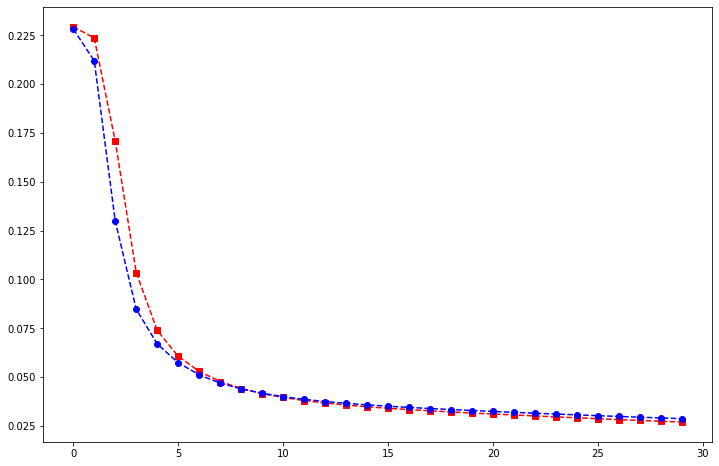

In [34]:
fig=plt.subplots(figsize=(12,8))
plt.rcParams["font.size"]=20
plt.plot(clf.log_loss,'rs--')
plt.plot(clf.log_loss_val,'bo--');

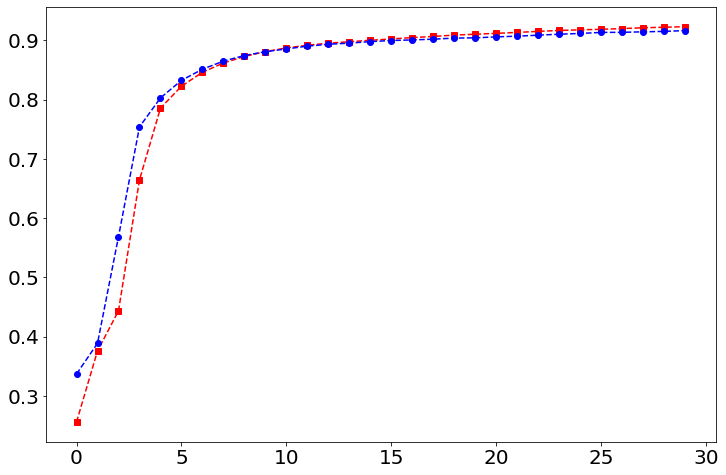

In [35]:
fig=plt.subplots(figsize=(12,8))
plt.rcParams["font.size"]=20
plt.plot(clf.log_acc,'rs--')
plt.plot(clf.log_acc_val,'bo--');

Estimation Reseult/correct results


<ipython-input-42-dcfbbcda29dd>:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  false_list=np.where(true_false==False)[0].astype(np.int)


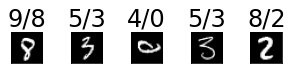

In [42]:
import numpy as np
import matplotlib.pyplot as plt

num=5
print('Estimation Reseult/correct results')

true_false=y_pred==y_val
false_list=np.where(true_false==False)[0].astype(np.int)
if false_list.shape[0]<num:
   num=false_list[0]
fig=plt.figure(figsize=(6,6))
fig.subplots_adjust(left=0, right=0.8, bottom=0, top=0.8, hspace=1, wspace=0.3)
for i in range(num):
    ax=fig.add_subplot(6,6,i+1,xticks=[],yticks=[])
    ax.set_title("{}/{}".format(y_pred[false_list[i]],y_val[false_list[i]]))
    ax.imshow(x_val.reshape(-1,28,28)[false_list[i]],cmap='gray')



